In [1]:
#@title Run this to load some packages! { display-mode: "form" }
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import gym
from IPython.display import HTML

import tqdm

ats = {1: "hit", 0:"stay"}

def play_blackjack(epsilon, print_steps=False):
  ### YOUR CODE HERE ###
  game = []
  state = blackjack.reset()
  game_over = False
  while game_over == False:
      if print_steps: 
        print("Your cards: ", blackjack.player)
        print_state(state)
      action = epsilon_greedy(state, epsilon)
      if print_steps: print(f"Agents chooses to {ats[action]}")
      next_state, reward, game_over, _ = blackjack.step(action)
      game.append((state, action))
      state = next_state
      if game_over:
        if print_steps:
          print("Your cards: ", blackjack.player)
          print_state(state)
          print("Game over!")
          print(f"Dealer has {blackjack.dealer}")
          print(rtm[reward])
        game.append(reward)    
  return game
  ### END CODE ###

def get_best_action(hand_val, dealer_card, usable_ace):
    state = (hand_val, dealer_card, usable_ace)

    # Compute Q(state, True)
    if num_games[(state,True)] == 0:
      Q_state_true = 0
    else:
      Q_state_true = sum_rewards[(state,True)] / num_games[(state,True)]
    
    # Compute Q(state, False)
    if num_games[(state,False)] == 0:
      Q_state_false = 0
    else:
      Q_state_false = sum_rewards[(state,False)] / num_games[(state,False)]

    return Q_state_true >= Q_state_false

def make_subplot(ax, usable_ace):
    x_coords = np.arange(1, 11) # dealer's cards
    y_coords = np.arange(11, 22) # gambler's hand values
    Z = np.array([[get_best_action(y, x, usable_ace) for x in x_coords] for y in y_coords])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Set1', 2), extent=[0.5, 10.5, 21.5, 10.5])
    plt.xticks(x_coords)
    plt.yticks(y_coords)
    plt.gca().invert_yaxis()
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    col1_patch = mpatches.Patch(color='darkgray', label='Hit')
    col2_patch = mpatches.Patch(color='red', label='Stick')
    plt.legend(handles=[col1_patch, col2_patch])

def plot_strategy():
  fig = plt.figure(figsize=(13, 13))
  ax = fig.add_subplot(121)
  ax.set_title('Usable Ace')
  make_subplot(ax, True)
  ax = fig.add_subplot(122)
  ax.set_title('No Usable Ace')
  make_subplot(ax, False)
  plt.show()

def best_action(state):
  ### YOUR CODE HERE ###
  # Compute Q(state, True)
  if num_games[(state,True)] == 0:
    Q_state_true = 0
  else:
    Q_state_true = sum_rewards[(state,True)] / num_games[(state,True)]
  
  # Compute Q(state, False)
  if num_games[(state,False)] == 0:
    Q_state_false = 0
  else:
    Q_state_false = sum_rewards[(state,False)] / num_games[(state,False)]

  return Q_state_true >= Q_state_false
  ### END CODE ###

def print_state(state):
  print()
  print("Hand value:", state[0])
  print("Dealer's card:", state[1])
  print("Useable ace?:", state[2])
  print("-----")

rtm = {0:"It's a tie!", -1: "You lose!", 1:"You win!"}
def play_human(blackjack):
  print()
  state = blackjack.reset()
  print("Your cards: ", blackjack.player)
  print("Hand value:", state[0])
  print("Dealer's card:", state[1])
  print("Useable ace?:", state[2])
  print("-----")

  while True:
    move = input('1 for hit 0 for stay: ') == '1'
    state, reward, game_over, _ = blackjack.step(move)
    print("Your cards: ", blackjack.player)
    print("Hand value:", state[0])
    print("Dealer's card:", state[1])
    print("Useable ace?:", state[2])
    print("-----")
    if game_over:
      print("Game over!")
      print(f"Dealer has {blackjack.dealer}")
      print(rtm[reward])
      break
  return reward

def play_n_times(blackjack, n):
  return np.mean([play_human(blackjack) for _ in range(n)])

sum_rewards = Counter()
num_games = Counter()



# Reinforcement Learning
By now, you've probably heard of the term 'reinforcement learning'. Today, we'll see exactly what that means and apply it to the widely played game of blackjack! Reinforcement learning is all about training agents to make optimal decisions in certain states.


**Here are some examples of what RL can do**. 


![](https://lh3.googleusercontent.com/cTaZiZNod4_aZxSYzV-MuAzavS87y838E9Zp8BHrz65_DLi3cJCESl0sDO2ucRxLByeiJ9fQFx4kC8c-6wKivikliGgNFd7c7WIfKfQ=w1440)





In [2]:
#@title Run to see an example of a RL agent learning to play breakout!

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V1eYniJ0Rnk" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


![](https://www.thesprucepets.com/thmb/64ApN7vccbRhZ5mnwXLyYUjt5ig=/450x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-992416282-5c296bcdc9e77c00012eb55d.jpg)

**Discuss:** How do you train a pet?

![](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/beagle-with-treat-royalty-free-image-172977570-1559147501.jpg?crop=0.665xw:1.00xh;0.119xw,0&resize=640:*)

We'll see how we can apply similar concepts to 'train' RL agents. **The techniques we'll talk about today drive technologies that allow computers to beat humans in chess, go, and videogames; autonomous driving; and robotic controls!**

# Blackjack

![](https://upload.wikimedia.org/wikipedia/commons/3/33/Blackjack21.jpg)

To motivate our discussion, we'll use the game of blackjack. Though you can be sure that the odds are *always* against the gambler, certain play strategies are better than others. Despite Blackjack having been played since the 17th century, it was not until 1956 that a team of statisticians managed to find the provably optimal play strategy through a lengthy series of probability calculations!

Just to make sure everyone knows how to play, here are the rules:


* You and the dealer each start with two cards. You can see both of your cards and one of the dealer's cards
* You decide to either "hit" or "stay"
* "hit" means you draw another card
* "stay" means you're done!
* The goal is to make the sum of your cards higher than the dealers, but not higher than 21.
* J, Q, K are each worth 10
* A is worth either 1 or 11 (whichever gives you the highest sum without going over 21)
* Dealer gets to pick cards after you're done


Don't worry, we can play a couple of times to get the hang of it!

In [3]:
blackjack = gym.make('Blackjack-v0')

In [4]:
play_human(blackjack)


Your cards:  [7, 7]
Hand value: 14
Dealer's card: 2
Useable ace?: False
-----
1 for hit 0 for stay: 1
Your cards:  [7, 7, 6]
Hand value: 20
Dealer's card: 2
Useable ace?: False
-----
1 for hit 0 for stay: 0
Your cards:  [7, 7, 6]
Hand value: 20
Dealer's card: 2
Useable ace?: False
-----
Game over!
Dealer has [2, 8, 7]
You win!


1.0

# Defining the world

In any reinforcement learning task we need to define the world in which the agent exists. There are 3 things we need to define: 

1. **states**: Where am I?
2. **actions**: What can I do?
4. **rewards**: How good were my decisions?

These interact together to define our world as follows!

![](https://dzone.com/storage/temp/6976061-screen-shot-2017-10-20-at-22200-pm.png)

**Discuss**: What are the states, actions and rewards in the following?

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQcCByH1UFKkeo8d0ZkKilw9LiuaG5sPFzIYQ&usqp=CAU)

![](https://i1.wp.com/metro.co.uk/wp-content/uploads/2019/09/Mobile_MarioKartTour_01-3eb4.jpg?quality=90&strip=all&zoom=1&resize=644%2C664&ssl=1)

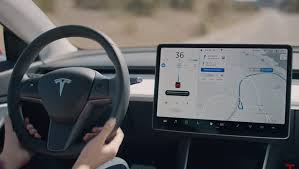

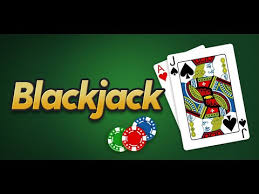


In blackjack, we'll define a **state** using the following format:

$s = $`(sum_of_cards_in_hand, dealers_card, useable_ace)`

where:

*   `sum_of_cards_in_hand` is sum of cards in hand (integer)
*   `dealers_card` is the dealer's visible card (integer) 
*   `useable_ace` is whether or not we have a useable ace (boolean)

The **actions** are to hit or to stay.

Because we are interested in training our agent to win as much as possible, we'll define a simple **reward** function which is $+1$ upon winning, $-1$ upon losing, and $0$ at all intermediate (i.e. non-game-ending) states, as well as upon tieing. We might make several moves before we get get a non-zero reward!

# What are we trying to learn again?

**Discuss**: Given this a world described by **states, actions**, and **rewards**. What are we trying to have our agent learn? 

Hint: Think of the agent as a hedonist. They are trying to rack up as much reward as possible!


![](https://dzone.com/storage/temp/6976061-screen-shot-2017-10-20-at-22200-pm.png)

# Policy

We're trying to learn a **policy**: rules for how we'll select **actions** based on the **state** of the world. The objective is to learn a policy that gets us the largest **reward** possible!

# Value

Let's define the **value** $Q(s, a)$ of an action $a$, at state $s$ as the expected future reward of taking an action at a certain state. Think $Q$ for quality: what payoff should we expect with this move?

**Discuss:** if we have access to $Q$, what would be a good policy for the agent?? 

We'll define a couple of simple worlds to test our function. Here are two examples:



In [6]:
q_traffic = {('red', 'go'):-1, ('green', 'go'):1, ("red", 'stop'):1, ('green', 'stop'):-0.5}
traffic_state = 'red'
actions_traffic = ['go', 'stop']

black_jack_state = 21
q_black_jack = {(21, 'hit'): -1, (21, 'stay'): 1} # this would have more... 
actions_black_jack = ['hit', 'stay']

**Question:** Explain what q_traffic is. Do the values make sense? How about q_black_jack?

**Exercise:** Implement your policy! Your policy should return the best action given a state, the value function, and a list of possible actions!


In [12]:
def q_policy_implementation(s, q, actions):
  """
  s:       is the state
  q:       is a dictionary mapping tuples (s, a) to their value Q(s, a)
           i.e q[(s, a)] gets the value of (s, a).
  actions: is a list of possible action
  """
  best_action, best_value = None, -1000
  for (state, action), val in q.items():
    ### BEGIN CODE #####
    print("state: " + str(state))
    print("action: " + str(action))
    print("value: " + str(val))
    if state == s and val >= best_value:
      best_value = val
      best_action = action
    ### END CODE ########
  print ("State:",s,"Action:",action)
  return (action)
  
# ===== Read this to see what the test is doing! =======
assert(q_policy_implementation(traffic_state, q_traffic, actions_traffic) == 'stop' )
assert(q_policy_implementation(black_jack_state, q_black_jack, actions_black_jack) == 'stay')

print("All tests passed :)")

state: red
action: go
value: -1
state: green
action: go
value: 1
state: red
action: stop
value: 1
state: green
action: stop
value: -0.5
State: red Action: stop
state: 21
action: hit
value: -1
state: 21
action: stay
value: 1
State: 21 Action: stay
All tests passed :)


**Optional Exercise:** Make your own world by defining the value function, current state and possible actions to test if your function works!


In [ ]:
## BEGIN CODE

## END CODE

Note that in real life we don't get a nice dictionary with our value function, so we'll have to learn it! This is the core idea behind our algorithm for today, which is called **Q-learning**. By experimenting with different actions, we'll learn what tends to happen when we make an action from a particular state.


# Q-Learning - Estimating Value

In order to learn $Q$, we'll repeat the following two steps:
1. Run an episode: have the agent interact with the world in some way (more on how later!)
2. Update the value, $Q(s, a)$, for each $(s, a)$ pair that occurred in the episode based on the rewards that we got!

For blackjack this is: 
1.   Play a game of Blackjack.
2.   Update the $Q(s,a)$ value, for each $(s,a)$ pair that occurred in the game, based on whether we won or lost at the end.



## Updating the Value Estimates

We can represent our game of blackjack like this:

$s_1, a_1, s_2, a_2, \ldots, s_n, a_n, r$

Where $r$ is the reward received at the end of the game: we're in a state, we take an action, repeat. Eventually, the game ends and we get a reward.

One complication here is that Blackjack games last for a variable number of moves, so we don't know what $n$ is upfront!

Suppose that, in code, this gameplay data is given you in the following form:

`game = [(s_1,a_1), (s_2,a_2), ... , (s_n,a_n), r]`

That is, `game` is a `List` of $n$ `Tuples` (each of which contains a state and an action) followed by a single reward at the end.

We'll keep a tally of the rewards we get for each action in each state, so that we can find the average value.

**Exercise:** Write a function that takes a `game` as argument and updates `sum_rewards` and `num_games` appropriately.
* `sum_rewards[(s, a)]` is the total reward at the state `(s, a)`.
* `num_games[(s, a)]` is the number of times we've seen the state `(s, a)`.

At the start, the two dictionaries are both initialized so that the value for each `(s, a)` pair is 0.

In [14]:
def update_counters(game):
  reward = game[-1]
  for state_action_tuple in game[:-1]: #tuple is (s,a)
    ### YOUR CODE HERE ###  
    sum_rewards[state_action_tuple] += reward
    num_games[state_action_tuple] += 1
    pass
    ### END CODE ###

# Choosing Actions

Now we've got a way to learn the value of each action from each state!

But how do we use that to actually play the game while we're still learning? (What policy does the agent use while it is training?)

**Discuss:** Evaluate the following strategies:
* **Explore:** At any state, just randomly select an action!
* **Exploit:** At any state, pick the action we currently think is the best based on our value estimate! (this is the q_policy_implementation that we wrote!)

![](https://asopa.typepad.com/.a/6a00d83454f2ec69e2022ad3b982a8200b-800wi)


### Epsilon Greedy ($\varepsilon$-greedy) approach!

There is a trade-off between the two strategies above, so we compromise and mix the two strategies together! We'll use something called the $\varepsilon$-greedy algorithm! This algorithm explores (selects a random action) with probability $\varepsilon$, and exploits (selects the best action) with probability $(1-\varepsilon)$. 

**Exercise:** Read the code below to see how this policy is implemented!

In [15]:
def epsilon_greedy(state, epsilon):
  action = best_action(state)
  # Return best_action with probability 1-epsilon
  if np.random.binomial(n=1,p=1-epsilon):
    return action
  
  # Otherwise, return random action
  else:
    return np.random.binomial(n=1,p=0.5) # randomly chooses 0 or 1 for hit or stay in black jack 

# Training our Agent

Time to put it all together and actually train our agent to learn a good blackjack strategy!

We'll use the `play_blackjack(epsilon)` function which plays the game of blackjack using the epsilon_greedy policy, and then update our counters!

In [16]:
epsilon = 0.15
for iteration in tqdm.tqdm(range(1000000)):
  game = play_blackjack(epsilon)
  update_counters(game)


100%|██████████| 1000000/1000000 [01:07<00:00, 14772.97it/s]


# Testing it out! 
When it's done training, let's put it to the test and play some real games!
![](https://www.johnchow.com/wp-content/uploads/2012/03/lots-of-money.jpeg)

**Question:** Why is epsilon = 0 below?


In [18]:
play_blackjack(epsilon=0, print_steps=True)

Your cards:  [10, 5]

Hand value: 15
Dealer's card: 10
Useable ace?: False
-----
Agents chooses to hit
Your cards:  [10, 5, 5]

Hand value: 20
Dealer's card: 10
Useable ace?: False
-----
Agents chooses to stay
Your cards:  [10, 5, 5]

Hand value: 20
Dealer's card: 10
Useable ace?: False
-----
Game over!
Dealer has [10, 5, 2]
You win!


[((15, 10, False), True), ((20, 10, False), False), 1.0]

# Strategy Visualization

Let's take a look at the strategy our agent has learned! We've written a function called `plot_strategy()` that will do the visualization for you; give it a try!

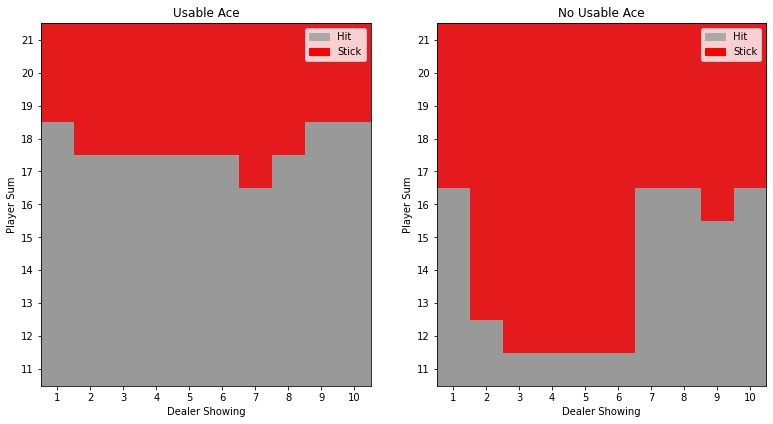

In [19]:
plot_strategy()

Compare the strategy that your agent learned to the optimal Blackjack strategy, shown below on the left. It should look pretty similar!

(Notice that the grid layouts differ a bit between our visualization and the one below; we plot the best actions aligned with the tick marks, whereas the following figure plots the best actions in between tick marks).


![alt text](https://ankonzoid.github.io/LearningX/classical_RL/blackjack/images/coverart.png)


# Optional: Questions to ponder
* We kept $\varepsilon$, our exploration probability, at a constant $0.15$. If you could change the exploration probability throughout the training (and you definitely can!), how would you? Why?
* We initialized our value estimates at $0$ for each state/action pair. How would our training behave differently if we initialized them to all $10$?
* How big is our table for storing the values in terms of $n_s$, the number of possible states, and $n_a$ the number of possible actions?
* If our states are images (think for example in robotics/self driving car applications which use cameras to model state), which have size say 128x128x3 pixels, each pixel taking a value from 0-255. What is $n_s$, the number of possible states?
* Given the above discussion, what is one fatal flaw for the $Q$-learning algorithm, and how might you address it?